In [1]:
import simpy as sp
import numpy as np
import matplotlib.pyplot as plt
import random
resources_count = [5,1,3] # prep/op/rec rooms total
timeavgs = [25, 40, 20, 40] # avg times for arrival/prep/op/rec
results = [] # list of all patient paths
resources_utilization = [] # list of resouce details
# patient severity should be done as modifier if/when is added. multiplies prep/op/req times.

In [4]:
def utilization_tracker(env, resources, interval): 
    # keeps track of amount of each resource in use, and waitlist lengths
    while True:
        prep = [len(resources[0].queue) , resources[0].count]
        op = [len(resources[1].queue) , resources[1].count]
        rec = [len(resources[2].queue) , resources[2].count]
        resources_utilization.append([prep, op, rec])
        yield env.timeout(interval)

In [5]:
def patient(env, resources):
    mydata = [0,0,0,0,0] # arrival, prep total, op required, op waited, rec total
    results.append(mydata) # mutable, edited below
    mydata[0] = env.now # arrival time

    # individual patient path through system
    prep = resources[0].request()
    yield prep # wait prep room
    yield env.timeout(random.expovariate(1/timeavgs[1])) # prep duration
    op = resources[1].request()
    yield op
    resources[0].release(prep) # op room free, release prep
    mydata[1] = env.now # record time ended in prep room
    yield env.timeout(random.expovariate(1/timeavgs[2])) # op duration
    rec = resources[2].request()
    mydata[2] = env.now # *required* time in op room
    yield rec
    resources[1].release(op) # op free once rec opens
    mydata[3] = env.now # *total* time in op room
    yield env.timeout(random.expovariate(1/timeavgs[3])) # op duration
    resources[2].release(rec) # rec done
    mydata[4] = env.now
    
    # calculate times spent instead of simulation times:
    mydata[4] -= mydata[3]
    mydata[3] -= mydata[2]
    mydata[2] -= mydata[1]
    mydata[1] -= mydata[0]

In [6]:
def patient_generator(env, resources):
    while True:
        env.process(patient(env, resources))
        # print('ptgen:', env.now)
        yield env.timeout(random.expovariate(1/timeavgs[0])) # avg. interarrival 25, exponential distr.

In [7]:
env = sp.core.Environment(0) # environment initial time is 0.

# clear for new simulation
results = []
resources_utilization = []

prep = sp.resources.resource.Resource(env, capacity=resources_count[0])
op = sp.resources.resource.Resource(env, capacity=resources_count[1])
rec = sp.resources.resource.Resource(env, capacity=resources_count[2])
resources = [prep, op, rec]

env.process(utilization_tracker(env, resources, 20))
env.process(patient_generator(env, resources))

env.run(until=1000)

In [83]:
# print('resource utilization') # waiting, using, waiting, using ... for each resource
# print(resources_utilization)
# print('patient paths:')
# for res in results:
#   print(res)

op utilization %: 0.6294403725024733
wait queue for prep room


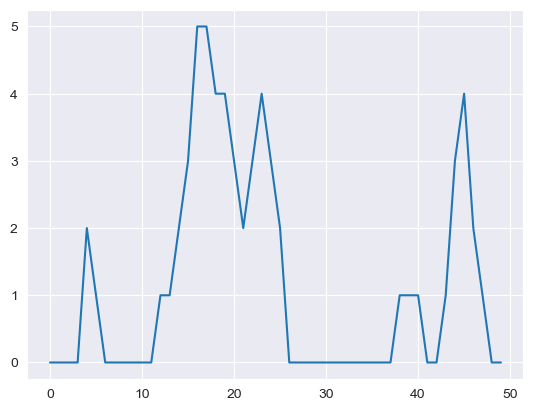

In [8]:
wq = np.array(resources_utilization)[:,1,0] # op room waitlist
# print(wq)
op_use = sum(np.array(results)[:,2])
op_wait = sum(np.array(results)[:,3])
print('op utilization %:', op_use / (op_use + op_wait))
print('wait queue for prep room')
plt.plot(range(0,len(wq)),wq)